In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
import utils as utils
import cartopy.crs as ccrs

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_simpleFaIRGP as fairgp
import src.evaluation.visualisation as vis

<IPython.core.display.Javascript object>

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/SimpleSpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [112]:
model.likelihood.noise = 3.

In [113]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [114]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
prior_mean = model._compute_mean(test_scenarios[0])
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [115]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

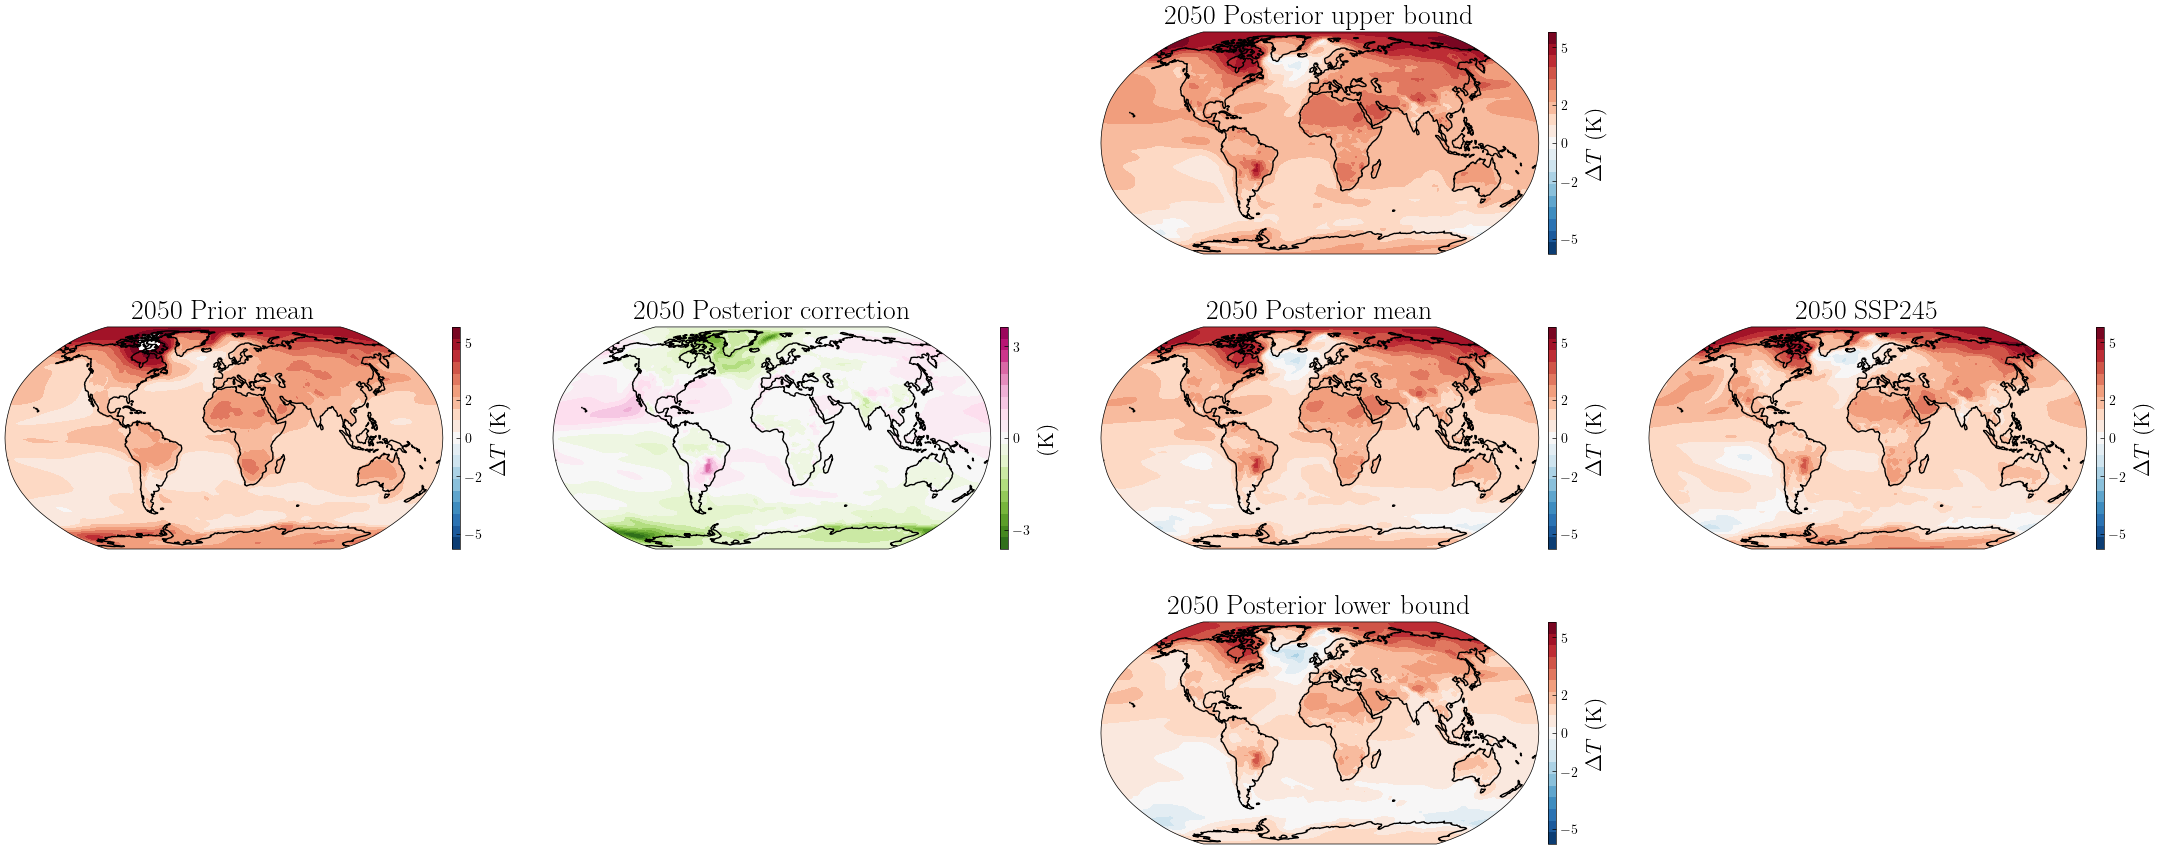

In [117]:
idx = 35

fig, ax, cbars = vis.plot_tryptych(xr_prior_mean.isel(time=idx),
                                xr_posterior_correction.isel(time=idx),
                                xr_posterior_mean.isel(time=idx),
                                xr_posterior_ub.isel(time=idx),
                                xr_posterior_lb.isel(time=idx),
                                xr_groundtruth.isel(time=idx))

cbar_fontsize = 18
ticks = [-5, -2, 0, 2, 5]

for i, c in enumerate(cbars):
    if i == 1:
        continue
    c.set_ticks(ticks)
    c.set_label(r'$\Delta T$ (K)', fontsize=16)
cbars[1].set_label('(K)', fontsize=16)
cbars[1].set_ticks([-3, 0, 3])

ax[1, 0].set_title("2050 Prior mean", fontsize=20)
ax[1, 1].set_title("2050 Posterior correction", fontsize=20)
ax[0, 2].set_title("2050 Posterior upper bound", fontsize=20)
ax[1, 2].set_title("2050 Posterior mean", fontsize=20)
ax[2, 2].set_title("2050 Posterior lower bound", fontsize=20)
ax[1, 3].set_title("2050 SSP245", fontsize=20)

plt.savefig('./SSP245-spatial-prediction-FaIRGP.png', dpi=300)

plt.show()

In [149]:
mean_bias = posterior_mean - test_tas
is_in_CR = (test_tas >= posterior_lb) & (test_tas <= posterior_ub)

xr_bias = encapsulate(mean_bias)
xr_isin_CR = encapsulate(is_in_CR.int())

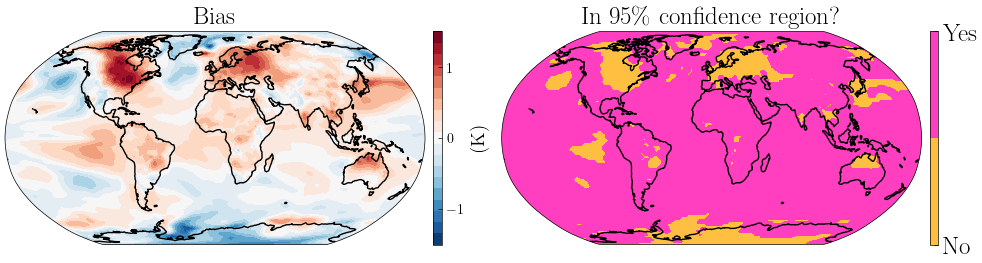

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.isel(time=idx), fig, ax[0], colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-1, 0, 1])

_, __, cbar = vis.plot_contourf_on_ax(xr_isin_CR.isel(time=idx), fig, ax[1], levels=3, 
                        colorbar=True, vmin=0, vmax=1., cmap='spring_r')
cbar.set_label('', fontsize=2)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'], fontsize=18)

ax[0].set_title("Bias", fontsize=18)
ax[1].set_title("In 95\% confidence region?", fontsize=18)

plt.tight_layout()

plt.savefig('./SSP245-spatial-comparison-FaIRGP.png', dpi=300)
plt.show()

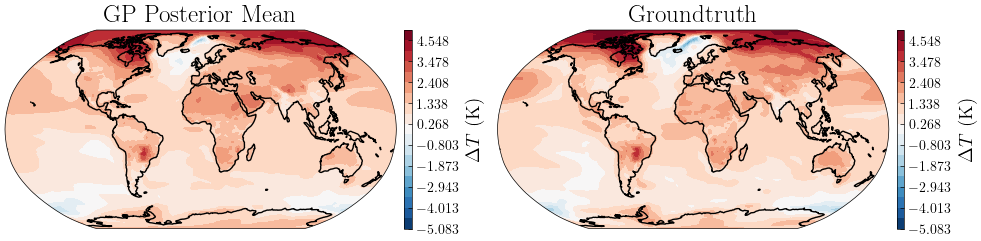

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 20

vmax = max(posterior_mean[idx].max(), test_tas[idx].max())

vis.plot_contourf_on_ax(xr_posterior_mean.isel(time=idx), fig, ax[0], colorbar=True, vmax=vmax)
vis.plot_contourf_on_ax(xr_groundtruth.isel(time=idx), fig, ax[1], colorbar=True, vmax=vmax)

ax[0].set_title("GP Posterior Mean", fontsize=18)
ax[1].set_title("Groundtruth", fontsize=18)

plt.tight_layout()
plt.show()